In [ ]:
# 이거 실행(설치)하고 런타임 재시작 하면 한글 출력 가능
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# 짱제 path
path = '/content/drive/MyDrive/5팀_공유폴더/작업결과물/dataset/'

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import plotly.express as px
import matplotlib
import numpy as np
import warnings

plt.rc('font', family='NanumBarunGothic') 
warnings.filterwarnings(action='ignore')

# path = '/content/drive/My Drive/Colab Notebooks/sample/lmemdata/'

data_1_6 = pd.read_csv(path+'lmembers_features_통합(train또는1~6분기데이터).csv')
data_1_6[['거주지역','구매금액이큰제휴사','방문빈도가높은제휴사']] = data_1_6[['거주지역','구매금액이큰제휴사','방문빈도가높은제휴사']].astype('category')

data_2_7 = pd.read_csv(path+'lmembers_features_통합(test또는2~7분기데이터).csv')
data_2_7[['거주지역','구매금액이큰제휴사','방문빈도가높은제휴사']] = data_2_7[['거주지역','구매금액이큰제휴사','방문빈도가높은제휴사']].astype('category')

data_1_6 = data_1_6.set_index('고객번호')
data_2_7 = data_2_7.set_index('고객번호')

In [8]:
# 어떤 feature로  clustering할 것인가

user_cluster_df = data_1_6[['Monetary', 'A_Monetary_실제지출', 'B_Monetary_실제지출', 'C_Monetary_실제지출','고급일반비율', 'fluctuation','분기매출증가']].copy() # svm에서 중요했던 피쳐
# user_cluster_df = data_2_7[['Monetary', 'A_Monetary_실제지출', 'B_Monetary_실제지출', 'C_Monetary_실제지출','D_Monetary_실제지출', 'fluctuation','분기매출증가']].copy() # svm에서 중요했던 피쳐
# user_cluster_df = data_1_6[['Monetary', 'A_Monetary_실제지출', '구매횟수', 'Frequency','C_recency', 'fluctuation','분기매출증가']].copy()  #lgbm 2_7 상위 피쳐 -> 1_6에 써보기
# user_cluster_df = data_1_6[['Monetary', 'A_Monetary_실제지출', 'f_명품', 'f_캐주얼','f_스포츠', 'f_가공식품','분기매출증가']].copy() # lgbm 1_6 상위 피쳐
# user_cluster_df = data_2_7[['Monetary', 'A_Monetary_실제지출', '구매횟수', 'Frequency','C_recency', 'fluctuation','분기매출증가']].copy()

In [9]:
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from datetime import datetime


#X_features_scaled = StandardScaler().fit_transform(data_1_6)
X_features_scaled = RobustScaler().fit_transform(user_cluster_df)
#X_features_scaled = StandardScaler().fit_transform(pca_transformed)

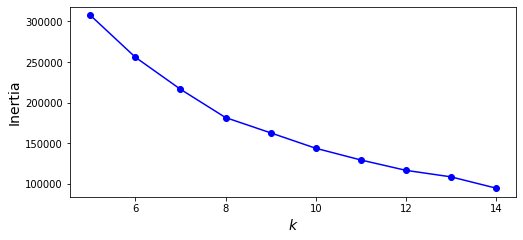

In [10]:
# kmeans 엘보우 그래프 그리기

r1 = 5   # 몇개  그룹으로 할것인가 여기서부터
r2 = 15  #  여기까지 

kmeans_per_k = [KMeans(n_clusters=k, random_state=42, max_iter=300).fit(X_features_scaled)
                for k in range(r1, r2)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(r1, r2), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
# plt.axis([3, 27, 1000, 200000])   # 이거 범위 조절해야 그래프가 보일 수 있음
plt.show()

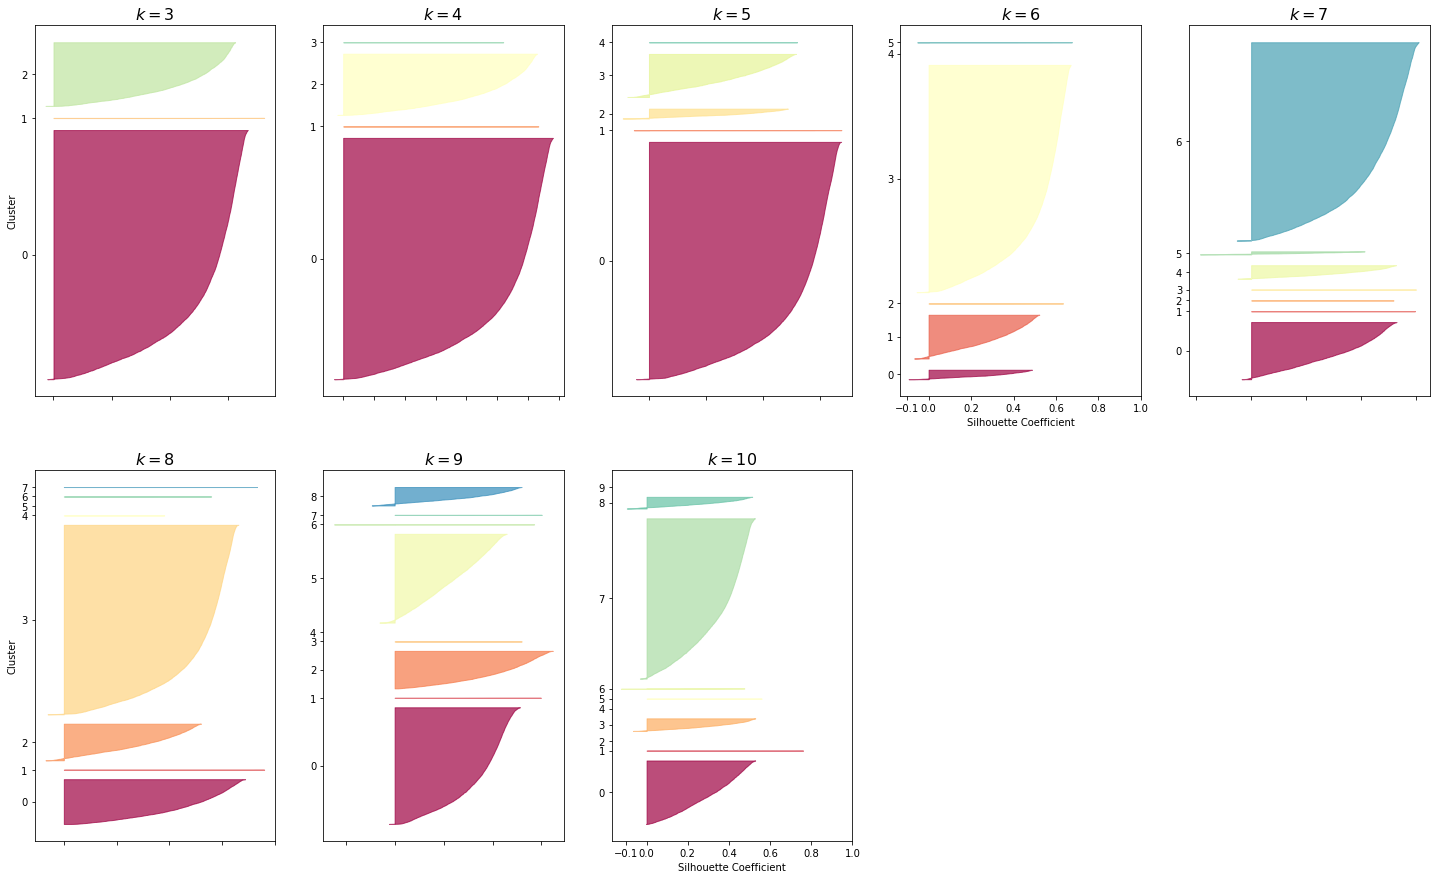

In [11]:
# kmeans 실루엣 다이어그램

from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.rc('font', family='Malgun Gothic') # For Windows
plt.figure(figsize=(25, 15))

co = 1;
for k in (3, 4, 5, 6, 7, 8, 9,10):
    plt.subplot(2, 5, co)
    co +=1
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X_features_scaled, y_pred)

    padding = len(X_features_scaled) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = matplotlib.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 8):
        plt.ylabel("Cluster")
    
    if k in (6, 10):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    # plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)


plt.show()

In [22]:
# 몇개로 cluster할것인가
# 3으로하면 엄청 높음 ...
n_cluster = 4

In [23]:
kmeans = KMeans(n_clusters=n_cluster, init='k-means++', max_iter=1000,random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
user_cluster_df['kmeans_cluster'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))
labels

실루엣 스코어는 : 0.529


array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [24]:
# 전체 데이터셋에 대한 실루엣계수 평균은 절대적인 기준이 될 수는 없기 때문에 개별적인 실루엣 계수를 확인해줘야함
import sklearn
sklearn.metrics.silhouette_samples(X_features_scaled,labels)

array([0.4743249 , 0.48768288, 0.30265358, ..., 0.52255968, 0.54886918,
       0.57693767])

In [ ]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=n_cluster, n_init=10)
B_G_labels= bgm.fit_predict(X_features_scaled)
user_cluster_df['Bayesian_Gaussian_cluster'] = B_G_labels
sorted(np.round(bgm.weights_, 2))

[0.0, 0.01, 0.01, 0.02, 0.03, 0.08, 0.12, 0.18, 0.27, 0.27]

In [ ]:
user_cluster_df_origin = user_cluster_df.copy()  

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

rb_scaler = RobustScaler()
mm_scaler = MinMaxScaler()
st_scaler = StandardScaler()

user_cluster_df.iloc[:,0:4] = user_cluster_df.iloc[:,0:4].replace(0,1)
user_cluster_df.iloc[:,0:4] = user_cluster_df.iloc[:,0:4].apply(np.log)
user_cluster_df.iloc[:,:7] = mm_scaler.fit_transform(user_cluster_df.iloc[:,:7])

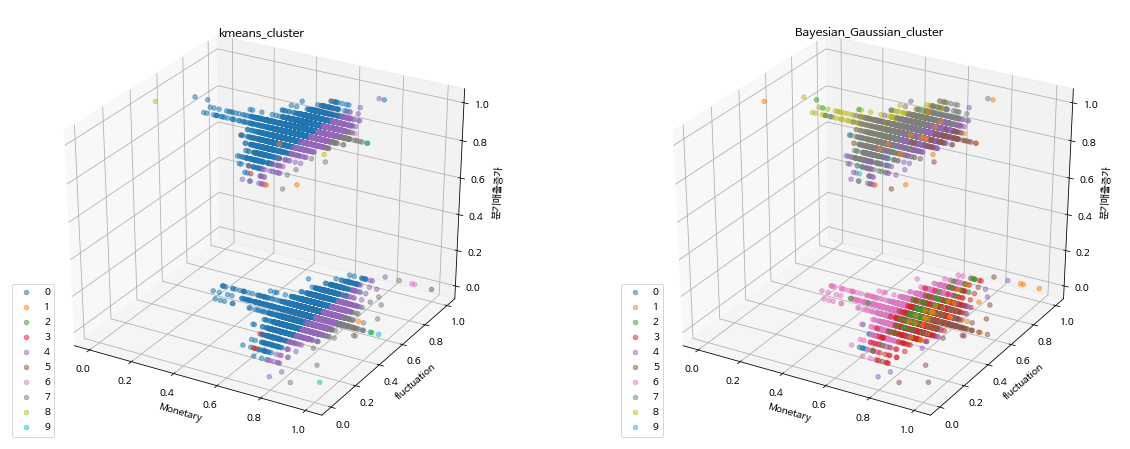

In [ ]:
# 3차원 clustering 시각화
from mpl_toolkits.mplot3d import Axes3D

col_n = 1 
row_n = 2

fig = plt.figure(figsize=(20,8*col_n));

for i, cl in enumerate(['kmeans_cluster',	'Bayesian_Gaussian_cluster']) :
  groups = user_cluster_df.groupby(cl)

  ax = fig.add_subplot(col_n,row_n,i+1, projection='3d') #int(i/col_n),int(i%col_n);

  # 3차원 scatter 그래프
  for i, group in groups:
    #ax.scatter(user_rfm.iloc[:,0], user_rfm.iloc[:,1], user_rfm.iloc[:,2], alpha = 0.5);

#  ['A_Monetary_실제지출', 'B_Monetary_실제지출','C_Monetary_실제지출','D_Monetary_실제지출', 'Monetary', 'fluctuation', '분기매출증가','kmeans_cluster', 'Bayesian_Gaussian_cluster'],
    scatter = ax.scatter(group.iloc[:,0], group.iloc[:,5], group.iloc[:,6], label=i, alpha = 0.5);
    ax.set_xlabel(user_cluster_df.columns[0]);
    ax.set_ylabel(user_cluster_df.columns[5]);
    ax.set_zlabel(user_cluster_df.columns[6]);
  ax.legend(loc = 'lower left')
  ax.set_title(cl);

In [ ]:
# Bayesian_Gaussian_cluster 시각화
polar = user_cluster_df.groupby('Bayesian_Gaussian_cluster').mean().T.drop('kmeans_cluster', axis = 0)
lists =  user_cluster_df.Bayesian_Gaussian_cluster.value_counts().sort_index().values
# 그룹별 feature 시각화
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=5, specs=[[{'type': 'polar'}]*5]*2)

for i in range(n_cluster):
  fig.append_trace(go.Scatterpolar(
      name = 'Group'+str(i)+ ' ' + str(lists[i]) +'명',
      r = polar[i].values,
      theta = polar.index),int(i/5+1),i%5+1)

fig.update_traces(fill='toself')
fig.show()

In [ ]:
new_data_2_7 = pd.merge(data_2_7, user_cluster_df['Bayesian_Gaussian_cluster'], left_index = True, right_index = True, how = 'left')
new_data_2_7.groupby('Bayesian_Gaussian_cluster').agg(['mean','std'])

Recency              Frequency              \
                                 mean        std        mean         std   
Bayesian_Gaussian_cluster                                                  
0.0                        636.157993   6.039276  347.260843   56.748393   
1.0                        635.661972   4.136747  280.901408  140.065001   
2.0                        632.912037  23.981323  260.652778  107.187186   
3.0                        634.301412   8.867809  210.662842   87.183616   
4.0                        634.628242   9.403456  194.103746   70.426288   
5.0                        634.822581   5.769345  257.637097  110.128774   
6.0                        632.246948  23.712814  222.538592   76.969972   
7.0                        635.688247   3.696546  207.195684   80.989547   
8.0                        636.823010   2.989705  290.526006   75.392686   
9.0                        636.775472   2.193943  314.303774   96.368661   

                               Monetary                      성별            \
                                   mean           std      mean       std   
Bayesian_Gaussian_cluster                                                   
0.0                        9.350461e+06  4.515720e+06  0.201983  0.401604   
1.0                        1.747464e+08  2.606242e+08  0.408451  0.495046   
2.0                        2.463831e+07  1.177668e+07  0.217593  0.413567   
3.0                        5.922448e+07  3.389859e+07  0.167696  0.373679   
4.0                        1.180272e+08  6.034109e+07  0.170029  0.376201   
5.0                        2.750852e+08  3.389856e+08  0.282258  0.451924   
6.0                        1.720238e+07  1.201904e+07  0.178592  0.383046   
7.0                        3.056558e+07  2.353188e+07  0.166521  0.372602   
8.0                        8.996629e+06  3.737489e+06  0.182319  0.386143   
9.0                        2.502750e+07  1.578382e+07  0.166038  0.372466   

                                 연령대             ... f_트래디셔널  \
                                mean        std  ...          mean   
Bayesian_Gaussian_cluster                        ...                 
0.0                        42.975836   8.533660  ...    712.006196   
1.0                        44.718310   9.852024  ...    563.521127   
2.0                        42.662037   9.399240  ...    745.259259   
3.0                        44.902913   8.961006  ...    305.394086   
4.0                        45.475504   9.750729  ...    259.360231   
5.0                        44.798387  10.109144  ...    394.806452   
6.0                        42.460094   9.497645  ...    550.465540   
7.0                        42.158064  10.004525  ...    437.007874   
8.0                        42.834957   8.819324  ...    731.485756   
9.0                        43.698113   8.921173  ...    488.513208   

                                      f_피혁잡화             f_화장품  \
                                  std         mean         std       mean   
Bayesian_Gaussian_cluster                                                   
0.0                        452.850458   601.814126  489.472580  25.339529   
1.0                        499.339960   423.098592  496.999631  -0.704225   
2.0                        436.857954   509.351852  500.985992  32.365741   
3.0                        460.195755   358.210503  479.265783  10.786849   
4.0                        438.935444   380.262248  486.309457   5.126801   
5.0                        491.166765   379.241935  486.963436   8.032258   
6.0                        497.266245   461.696150  498.295172  21.689014   
7.0                        496.242457   440.844269  496.670241  16.274132   
8.0                        443.227521   556.003676  496.863998  16.741040   
9.0                        500.512143   428.060377  495.517358   7.133962   

                                      fluctuation              분기매출증가  \
                                  std        mean    

In [ ]:
user_cluster_df.groupby('Bayesian_Gaussian_cluster').agg(['mean','std'])

Monetary           A_Monetary_실제지출            \
                               mean       std            mean       std   
Bayesian_Gaussian_cluster                                                 
0                          0.619648  0.032313        0.597094  0.126754   
1                          0.766370  0.121257        0.705640  0.108067   
2                          0.673418  0.069991        0.621322  0.122318   
3                          0.741960  0.044194        0.811673  0.058177   
4                          0.773763  0.051409        0.854227  0.023276   
5                          0.824369  0.058611        0.876250  0.040295   
6                          0.651306  0.056110        0.695317  0.111240   
7                          0.676104  0.060118        0.767352  0.064081   
8                          0.609370  0.038567        0.577218  0.116431   
9                          0.672335  0.043360        0.731644  0.089116   

                          B_Monetary_실제지출           C_Monetary_실제지출            \
                                     mean       std            mean       std   
Bayesian_Gaussian_cluster                                                       
0                                0.557793  0.141576        0.771842  0.023873   
1                                0.713504  0.182713        0.782238  0.186533   
2                                0.774944  0.112316        0.560768  0.188944   
3                                0.598139  0.168013        0.534633  0.217159   
4                                0.582697  0.173318        0.478263  0.250190   
5                                0.636612  0.172771        0.533180  0.192874   
6                                0.659134  0.164400        0.437842  0.209065   
7                                0.612432  0.182751        0.426850  0.223534   
8                                0.677020  0.135264        0.588914  0.196619   
9                                0.590520  0.135449        0.752613  0.046706   

                             고급일반비율           fluctuation              분기매출증가  \
                               mean       std        mean       std      mean   
Bayesian_Gaussian_cluster                                                       
0                          0.523081  0.034204    0.560500  0.083577  0.000000   
1                          0.535003  0.170920    0.553438  0.172670  0.281690   
2                          0.594240  0.186624    0.519063  0.138467  0.490741   
3                          0.500053  0.047605    0.532605  0.086328  0.000000   
4                          0.490687  0.040741    0.483641  0.135056  0.855908   
5                          0.610064  0.138510    0.509013  0.128185  0.346774   
6                          0.545062  0.086180    0.548038  0.093091  0.000000   
7                          0.510945  0.066381    0.489596  0.107694  1.000000   
8                          0.560501  0.067218    0.518201  0.077740  1.000000   
9                          0.517855  0.035522    0.502331  0.095752  1.000000   

                                    kmeans_cluster            
                                std           mean       std  
Bayesian_Gaussian_cluster                                     
0                          0.000000       2.576208  1.045205  
1                          0.453025       3.521127  2.247914  
2                          0.501076       0.027778  0.288003  
3                          0.000000       3.130627  1.738454  
4                          0.351690       4.368876  1.710883  
5                          0.477874       5.556452  1.818167  
6                          0.000000       0.376453  1.168054  
7                          0.000000       1.076699  1.774382  
8                          0.000000       0.942841  1.392814  
9                          0.000000       2.026415  1.587778

In [ ]:
user_cluster_df_origin.groupby('Bayesian_Gaussian_cluster').agg(['mean','std'])

Monetary               A_Monetary_실제지출  \
                                   mean           std            mean   
Bayesian_Gaussian_cluster                                               
0                          9.830755e+06  4.788607e+06    2.182598e+06   
1                          1.878231e+08  3.313766e+08    3.303365e+07   
2                          2.412934e+07  1.159104e+07    3.994357e+06   
3                          6.339537e+07  3.604051e+07    7.787065e+07   
4                          1.056833e+08  6.425843e+07    1.630657e+08   
5                          2.669615e+08  3.226529e+08    3.639635e+08   
6                          1.816847e+07  1.265720e+07    1.595402e+07   
7                          2.790923e+07  2.191748e+07    3.699814e+07   
8                          8.485430e+06  3.604635e+06    1.051871e+06   
9                          2.314519e+07  1.510868e+07    2.297954e+07   

                                        B_Monetary_실제지출                \
                                    std            mean           std   
Bayesian_Gaussian_cluster                                               
0                          3.292807e+06    7.713196e+05  1.156830e+06   
1                          4.904257e+07    1.059305e+08  2.947927e+08   
2                          6.049657e+06    2.684407e+07  1.353911e+07   
3                          4.590272e+07    2.305323e+06  3.171895e+06   
4                          7.722092e+07    1.572302e+06  1.920391e+06   
5                          4.673490e+08    6.768321e+06  9.206792e+06   
6                          1.785520e+07    6.684180e+06  6.331831e+06   
7                          3.232243e+07    3.946264e+06  5.214643e+06   
8                          1.251242e+06    7.362756e+06  6.222798e+06   
9                          2.297856e+07    1.513282e+06  2.154490e+06   

                          C_Monetary_실제지출                  고급일반비율            \
                                     mean           std      mean       std   
Bayesian_Gaussian_cluster                                                     
0                            9.399950e+06  4.452325e+06  0.553553  0.032018   
1                            1.055234e+08  1.933499e+08  0.564713  0.159999   
2                            1.071967e+06  1.434676e+06  0.620166  0.174700   
3                            1.053353e+06  1.778760e+06  0.531996  0.044564   
4                            7.425097e+05  1.297006e+06  0.523229  0.038138   
5                            9.535120e+05  2.090937e+06  0.634979  0.129660   
6                            1.240113e+05  2.122885e+05  0.574129  0.080673   
7                            1.424433e+05  2.488810e+05  0.542193  0.062139   
8                            3.412205e+06  4.679444e+06  0.588582  0.062923   
9                            8.843832e+06  8.590740e+06  0.548661  0.033253   

                          fluctuation              분기매출증가            \
                                 mean       std      mean       std   
Bayesian_Gaussian_cluster                                             
0                            0.528501  1.420815  0.000000  0.000000   
1                            0.408451  2.935387  0.281690  0.453025   
2                           -0.175926  2.353933  0.490741  0.501076   
3                            0.054281  1.467578  0.000000  0.000000   
4                           -0.778098  2.295959  0.855908  0.351690   
5                           -0.346774  2.179149  0.346774  0.477874   
6                            0.316648  1.582542  0.000000  0.000000   
7                           -0.676874  1.830793  1.000000  0.000000   
8                           -0.190590  1.321580  1.000000  0.000000   
9                           -0.460377  1.627776  1.000000  0.000000   

                          kmeans_cluster            
                                    mean       std  
Bayesian_Gaussian_cluster                           
0                   

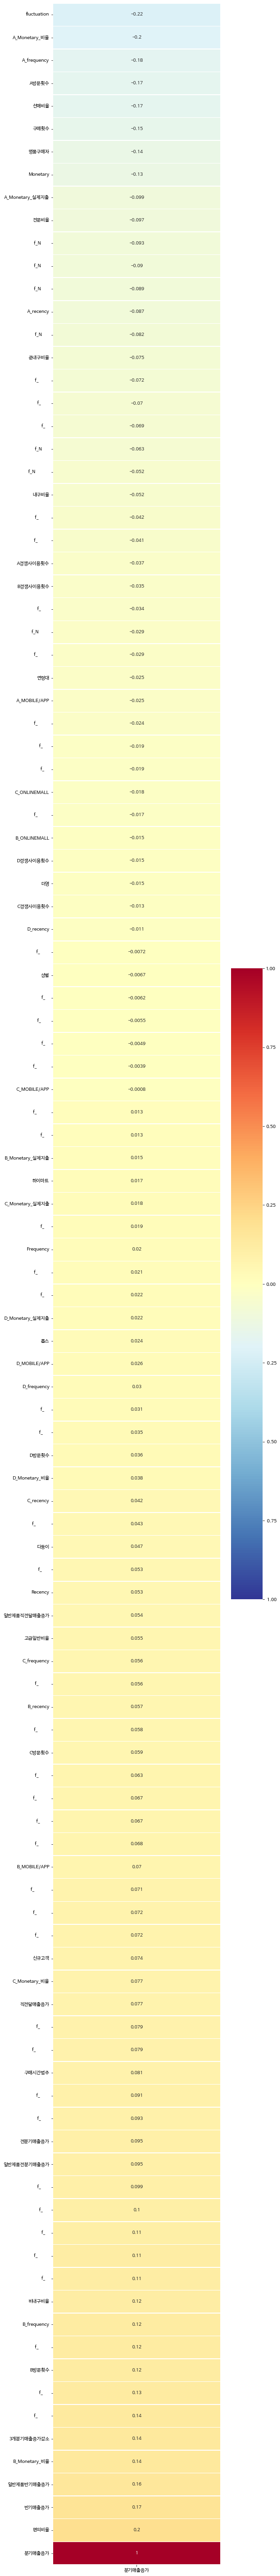

In [ ]:
cor = data_1_6.corr();
# cor = data_2_7.corr();
#sns.heatmap(cor, annot = True, cmap = 'RdBu');

# mask = np.zeros_like(cor, dtype=bool);
# mask[np.triu_indices_from(mask)] = True;

plt.figure(figsize = (8,100));
sns.heatmap(cor[['분기매출증가']].sort_values(by = '분기매출증가'), 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           );